# Modèles PyTorch - Classification et Régression

Ce notebook implémente deux modèles simples avec PyTorch:
1. **Classification**: Prédire si un étudiant va compléter le cours (Completed: 0 ou 1)
2. **Régression**: Prédire Quiz_Score_Avg, Project_Grade, Satisfaction_Rating, Time_Spent_Hours

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Vérifier si GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

Device utilisé: cpu


## 1. Chargement des données

In [7]:
# Classification
X_class = pd.read_csv('../data/processed/X_classification.csv')
y_class = pd.read_csv('../data/processed/y_classification.csv')

# Régression
X_reg = pd.read_csv('../data/processed/X_regression.csv')
y_reg = pd.read_csv('../data/processed/y_regression.csv')

print("CLASSIFICATION:")
print(f"X_class: {X_class.shape}")
print(f"y_class: {y_class.shape}")

print("\nREGRESSION:")
print(f"X_reg: {X_reg.shape}")
print(f"y_reg: {y_reg.shape}")

CLASSIFICATION:
X_class: (56172, 42)
y_class: (56172, 1)

REGRESSION:
X_reg: (56172, 37)
y_reg: (56172, 4)


---
# PARTIE 1: MODELE DE CLASSIFICATION
---

**Objectif**: Prédire si un étudiant va compléter le cours (0 ou 1)

In [8]:
# Préparation des données pour la classification
X_class_np = X_class.values
y_class_np = y_class.values.ravel()

# Train (70%) / Temp (30%)
X_train_class, X_temp_class, y_train_class, y_temp_class = train_test_split(
    X_class_np, y_class_np, test_size=0.30, random_state=42
)

# Test (15%) / Val (15%)
X_test_class, X_val_class, y_test_class, y_val_class = train_test_split(
    X_temp_class, y_temp_class, test_size=0.5, random_state=42
)

X_train_class_tensor = torch.FloatTensor(X_train_class).to(device)
X_val_class_tensor = torch.FloatTensor(X_val_class).to(device)
X_test_class_tensor = torch.FloatTensor(X_test_class).to(device)
y_train_class_tensor = torch.FloatTensor(y_train_class).to(device)
y_val_class_tensor = torch.FloatTensor(y_val_class).to(device)
y_test_class_tensor = torch.FloatTensor(y_test_class).to(device)

print(f"Données Classification: Train={X_train_class_tensor.shape[0]}, Val={X_val_class_tensor.shape[0]}, Test={X_test_class_tensor.shape[0]}")

Données Classification: Train=39320, Val=8426, Test=8426


In [9]:
# Modèle de Classification
class CourseCompletionClassifier(nn.Module):
    def __init__(self, input_dim):
        super(CourseCompletionClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.BatchNorm1d(256), 
            nn.ReLU(), 
            nn.Dropout(0.3),

            nn.Linear(256, 128),        
            nn.BatchNorm1d(128),  
            nn.ReLU(), 
            nn.Dropout(0.3),

            nn.Linear(128, 64),         
            nn.BatchNorm1d(64),  
            nn.ReLU(), 
            nn.Dropout(0.2),

            nn.Linear(64, 32),         
            nn.BatchNorm1d(32),  
            nn.ReLU(), 
            nn.Dropout(0.1),

            nn.Linear(32, 1),          
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model_class = CourseCompletionClassifier(X_train_class_tensor.shape[1]).to(device)

In [10]:
# Entraînement Classification avec Early Stopping
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_class.parameters(), lr=0.01)

best_val_loss = float('inf')
patience = 40
counter = 0
train_history, val_history = [], []

for epoch in range(500):
    
    # Train step
    model_class.train()

    optimizer.zero_grad()
    output = model_class(X_train_class_tensor)
    loss = criterion(output.squeeze(), y_train_class_tensor)
    loss.backward()
    optimizer.step()
    
    # Validation step
    model_class.eval()

    with torch.no_grad():
        val_out = model_class(X_val_class_tensor)
        val_loss = criterion(val_out.squeeze(), y_val_class_tensor)
    
    train_history.append(loss.item())
    val_history.append(val_loss.item())
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
    if (epoch+1) % 20 == 0: 
        print(f"Epoch {epoch+1:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# Sauvegarde du meilleur modèle
torch.save(model_class.state_dict(), '../models/torch_clf_model.pth')

Epoch 020 | Train Loss: 0.6543 | Val Loss: 0.6713
Epoch 040 | Train Loss: 0.6484 | Val Loss: 0.6614
Early stopping at epoch 48


Accuracy sur le test set: 0.6002 (60.02%)


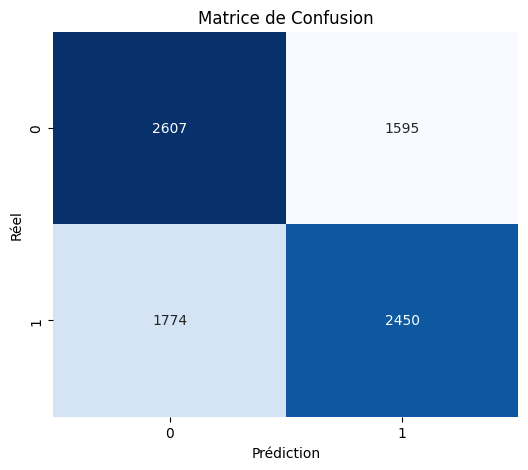


Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.62      0.61      4202
         1.0       0.61      0.58      0.59      4224

    accuracy                           0.60      8426
   macro avg       0.60      0.60      0.60      8426
weighted avg       0.60      0.60      0.60      8426



In [11]:
# EVALUATION - CLASSIFICATION
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model_class.eval()
with torch.no_grad():
    y_pred_test = model_class(X_test_class_tensor)
    y_pred_classes = (y_pred_test.squeeze() > 0.5).float()

y_pred_np = y_pred_classes.cpu().numpy()
y_test_np = y_test_class_tensor.cpu().numpy()

# Accuracy
accuracy = accuracy_score(y_test_np, y_pred_np)
print(f"Accuracy sur le test set: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_np)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_np))

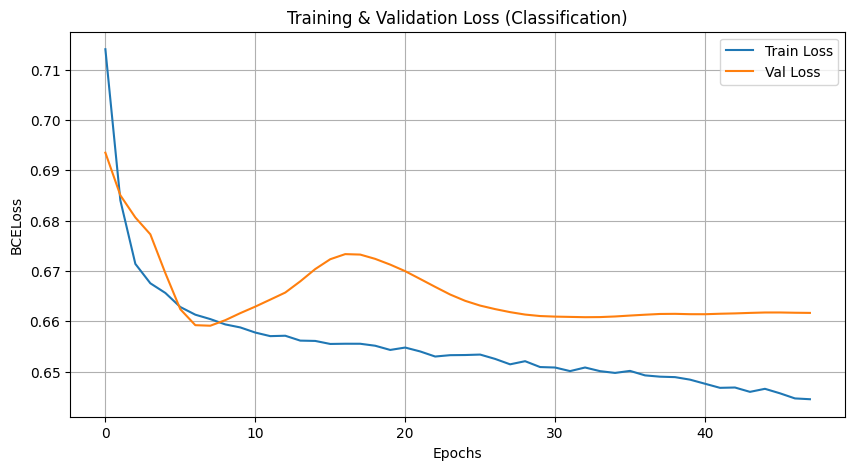

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Train Loss')
plt.plot(val_history, label='Val Loss')
plt.title('Training & Validation Loss (Classification)')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend()
plt.grid(True)
plt.show()

---
# PARTIE 2: MODELE DE REGRESSION
---

**Objectif**: Prédire 4 variables continues:
- Quiz_Score_Avg
- Project_Grade  
- Satisfaction_Rating
- Time_Spent_Hours

In [13]:
# Préparation des données pour la régression
X_reg_np = X_reg.values
y_reg_np = y_reg.values

# Train (70%) / Temp (30%)
X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    X_reg_np, y_reg_np, test_size=0.30, random_state=42
)

# test (15%) / val (15%)
X_test_reg, X_val_reg, y_test_reg, y_val_reg = train_test_split(
    X_temp_reg, y_temp_reg, test_size=0.5, random_state=42
)

# scalarisation de y
scaler_y = StandardScaler()
y_train_reg = scaler_y.fit_transform(y_train_reg)
y_val_reg = scaler_y.transform(y_val_reg)
y_test_reg = scaler_y.transform(y_test_reg)

# To tensor
X_train_reg = torch.FloatTensor(X_train_reg).to(device)
X_val_reg = torch.FloatTensor(X_val_reg).to(device)
X_test_reg = torch.FloatTensor(X_test_reg).to(device)
y_train_reg = torch.FloatTensor(y_train_reg).to(device)
y_val_reg = torch.FloatTensor(y_val_reg).to(device)
y_test_reg = torch.FloatTensor(y_test_reg).to(device)

print(f"Données Classification: Train={X_train_reg.shape[0]}, Val={X_val_reg.shape[0]}, Test={X_test_reg.shape[0]}")

Données Classification: Train=39320, Val=8426, Test=8426


In [14]:
# Modèle de Régression Amélioré
class StudentPerformanceRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StudentPerformanceRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.BatchNorm1d(256), 
            nn.ReLU(), 
            nn.Dropout(0.2),

            nn.Linear(256, 128),       
            nn.BatchNorm1d(128), 
            nn.ReLU(), 
            nn.Dropout(0.2),

            nn.Linear(128, 64),        
            nn.BatchNorm1d(64),  
            nn.ReLU(), 
            nn.Dropout(0.1),

            nn.Linear(64, 32),         
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model_reg = StudentPerformanceRegressor(X_train_reg.shape[1], y_train_reg.shape[1]).to(device)

In [15]:
# Entraînement Régression avec Early Stopping
criterion_reg = nn.HuberLoss(delta=1.0)
optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=0.02)

best_reg_loss = float('inf')
patience_reg = 40
counter_reg = 0
r_train_hist, r_val_hist = [], []

for epoch in range(500):

    model_reg.train()

    optimizer_reg.zero_grad()
    pred = model_reg(X_train_reg)
    loss = criterion_reg(pred, y_train_reg)
    loss.backward()
    optimizer_reg.step()
    
    model_reg.eval()
    
    with torch.no_grad():
        val_pred = model_reg(X_val_reg)
        val_loss = criterion_reg(val_pred, y_val_reg)
    
    r_train_hist.append(loss.item())
    r_val_hist.append(val_loss.item())

    if val_loss < best_reg_loss:
        best_reg_loss = val_loss
        counter_reg = 0
    else:
        counter_reg += 1
        if counter_reg >= patience_reg:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1:03d} | Train HuberLoss: {loss.item():.4f} | Val HuberLoss: {val_loss.item():.4f}")

# Sauvegarde du meilleur modèle
torch.save(model_reg.state_dict(), '../models/torch_reg_model.pth')

Epoch 020 | Train HuberLoss: 0.4066 | Val HuberLoss: 0.4168
Epoch 040 | Train HuberLoss: 0.3501 | Val HuberLoss: 0.3724
Epoch 060 | Train HuberLoss: 0.3264 | Val HuberLoss: 0.3446
Epoch 080 | Train HuberLoss: 0.3137 | Val HuberLoss: 0.3239
Epoch 100 | Train HuberLoss: 0.3137 | Val HuberLoss: 0.3266
Epoch 120 | Train HuberLoss: 0.3060 | Val HuberLoss: 0.3204
Epoch 140 | Train HuberLoss: 0.3041 | Val HuberLoss: 0.3230
Early stopping at epoch 158


In [16]:
# Évaluation Régression

model_reg.eval()
with torch.no_grad():
    y_pred_scaled = model_reg(X_test_reg).cpu().numpy()
    y_test_scaled = y_test_reg.cpu().numpy()

# Inverse transform
y_pred_final = scaler_y.inverse_transform(y_pred_scaled)
y_test_final = scaler_y.inverse_transform(y_test_scaled)

target_names = ["Quiz_Score_Avg", "Project_Grade", "Satisfaction_Rating", "Time_Spent_Hours"]
for i, col in enumerate(target_names):
    rmse = np.sqrt(mean_squared_error(y_test_final[:, i], y_pred_final[:, i]))
    r2 = r2_score(y_test_final[:, i], y_pred_final[:, i])
    print(f"{col:15} | RMSE: {rmse:.3f} | R2: {r2:.3f}")

Quiz_Score_Avg  | RMSE: 12.373 | R2: 0.033
Project_Grade   | RMSE: 3.557 | R2: 0.945
Satisfaction_Rating | RMSE: 0.701 | R2: -0.010
Time_Spent_Hours | RMSE: 3.824 | R2: -0.015


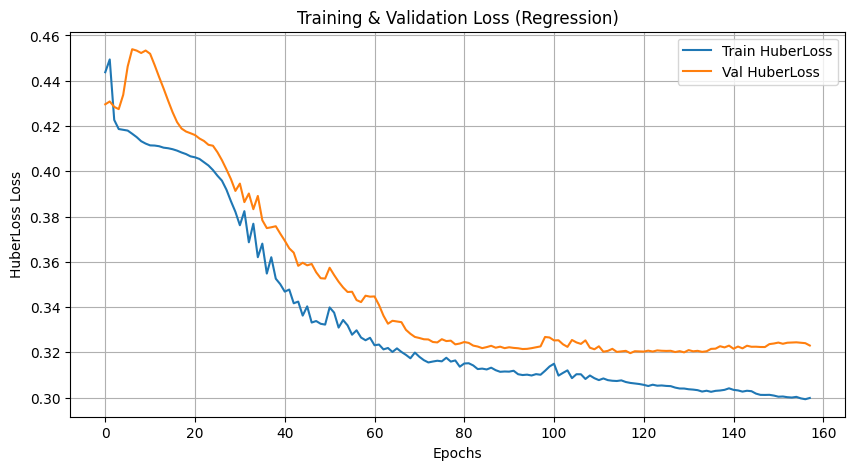

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(r_train_hist, label='Train HuberLoss')
plt.plot(r_val_hist, label='Val HuberLoss')
plt.title('Training & Validation Loss (Regression)')
plt.xlabel('Epochs')
plt.ylabel('HuberLoss Loss')
plt.legend()
plt.grid(True)
plt.show()

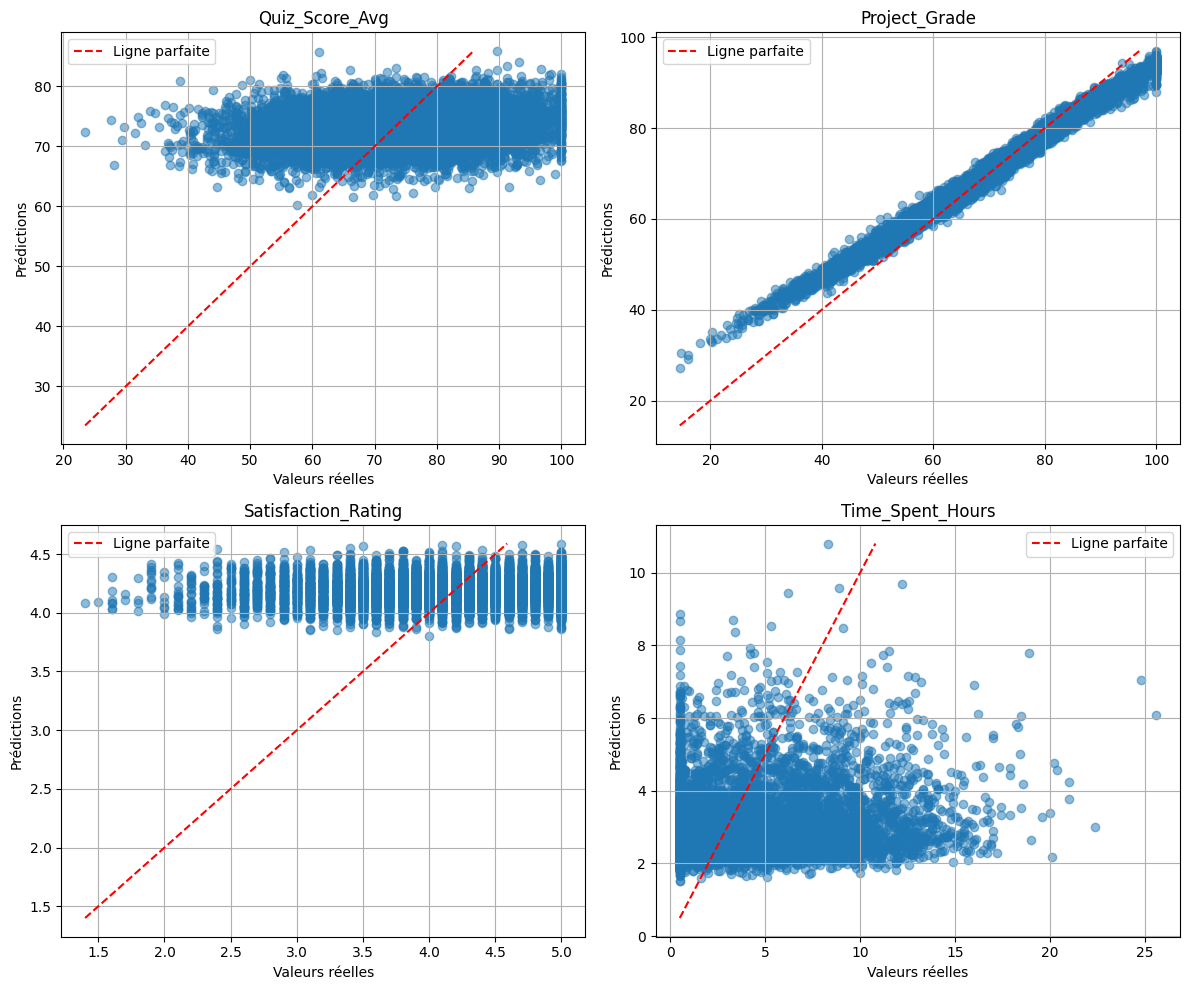

In [18]:
# VISUALISATION - PREDICTIONS vs VALEURS REELLES

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i, (ax, name) in enumerate(zip(axes, target_names)):
    ax.scatter(y_test_final[:, i], y_pred_final[:, i], alpha=0.5)
    ax.plot([y_test_final[:, i].min(), y_pred_final[:, i].max()],
            [y_test_final[:, i].min(), y_pred_final[:, i].max()],
            'r--', label='Ligne parfaite')
    ax.set_xlabel('Valeurs réelles')
    ax.set_ylabel('Prédictions')
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()